In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

df = pd.read_csv('telco_processed.csv')
print("Processed dataset shape:", df.shape)

print("Data types:")
print(df.dtypes.value_counts())

print("\nChecking for object/string columns:")
object_cols = df.select_dtypes(include=['object']).columns
print(object_cols)

Processed dataset shape: (7021, 30)
Data types:
int64      17
bool       10
float64     2
object      1
Name: count, dtype: int64

Checking for object/string columns:
Index(['TenureGroup'], dtype='object')


In [142]:
if len(object_cols) > 0:
    print("Converting categorical columns to numeric...")
    for col in object_cols:
        print(f"Converting {col}: {df[col].unique()}")
        df[col] = pd.factorize(df[col])[0]

print("Data types after conversion:")
print(df.dtypes.value_counts())

Converting categorical columns to numeric...
Converting TenureGroup: ['0-1yr' '2-4yr' '1-2yr' '4-6yr' nan]
Data types after conversion:
int64      18
bool       10
float64     2
Name: count, dtype: int64


In [143]:
X = df.drop('Churn', axis=1)
y = df['Churn']

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("Churn distribution:")
print(y.value_counts())

Features shape: (7021, 29)
Target shape: (7021,)
Churn distribution:
Churn
0    5164
1    1857
Name: count, dtype: int64


In [144]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Training churn distribution:")
print(y_train.value_counts())
print("Testing churn distribution:")
print(y_test.value_counts())

Training set shape: (5616, 29)
Testing set shape: (1405, 29)
Training churn distribution:
Churn
0    4131
1    1485
Name: count, dtype: int64
Testing churn distribution:
Churn
0    1033
1     372
Name: count, dtype: int64


In [145]:
dt_basic = DecisionTreeClassifier(random_state=42)
dt_basic.fit(X_train, y_train)

print("Basic Decision Tree trained successfully")

Basic Decision Tree trained successfully


In [146]:
y_pred_basic = dt_basic.predict(X_test)
y_pred_train = dt_basic.predict(X_train)

print("Predictions completed")

Predictions completed


In [147]:
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_basic)

print("=== BASIC DECISION TREE PERFORMANCE ===")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Accuracy Difference: {train_accuracy - test_accuracy:.4f}")

=== BASIC DECISION TREE PERFORMANCE ===
Training Accuracy: 0.9977
Testing Accuracy: 0.7253
Accuracy Difference: 0.2724


In [148]:
print("=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred_basic))

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1033
           1       0.48      0.52      0.50       372

    accuracy                           0.73      1405
   macro avg       0.65      0.66      0.65      1405
weighted avg       0.73      0.73      0.73      1405



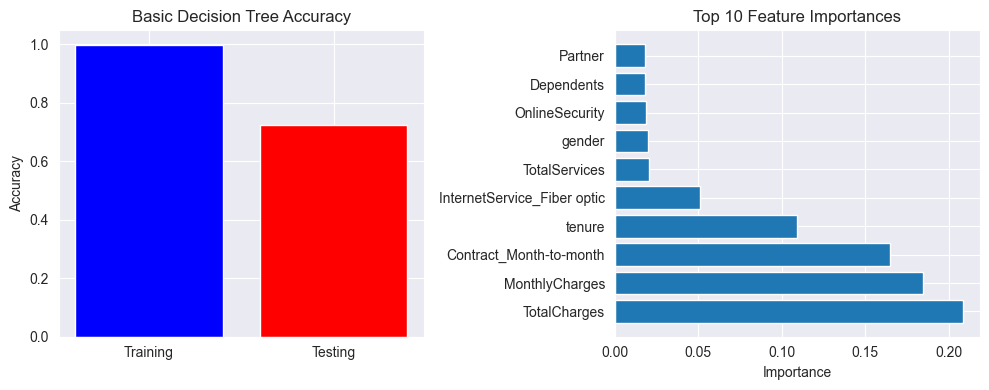

In [149]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
accuracies = [train_accuracy, test_accuracy]
labels = ['Training', 'Testing']
plt.bar(labels, accuracies, color=['blue', 'red'])
plt.title('Basic Decision Tree Accuracy')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': dt_basic.feature_importances_
}).sort_values('importance', ascending=False).head(10)

plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')

plt.tight_layout()
plt.show()

In [150]:
basic_results = {
    'model': 'DecisionTree_Basic',
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'overfitting_gap': train_accuracy - test_accuracy
}

print("Basic model results saved:")
for key, value in basic_results.items():
    print(f"{key}: {value}")

Basic model results saved:
model: DecisionTree_Basic
train_accuracy: 0.9976851851851852
test_accuracy: 0.7252669039145907
overfitting_gap: 0.27241828127059453


In [151]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score

In [152]:
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

print("Hyperparameter grid defined")
print("Total combinations:", len(param_grid['max_depth']) * len(param_grid['min_samples_split']) *
      len(param_grid['min_samples_leaf']) * len(param_grid['criterion']))

Hyperparameter grid defined
Total combinations: 192


In [153]:
dt_tuned = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=dt_tuned,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("GridSearchCV configured with 5-fold cross-validation")

GridSearchCV configured with 5-fold cross-validation


In [154]:
print("Starting hyperparameter tuning...")
grid_search.fit(X_train, y_train)

print("Hyperparameter tuning completed!")

Starting hyperparameter tuning...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
Hyperparameter tuning completed!


In [155]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("=== BEST PARAMETERS ===")
for param, value in best_params.items():
    print(f"{param}: {value}")

print(f"\nBest cross-validation score: {best_score:.4f}")

=== BEST PARAMETERS ===
criterion: entropy
max_depth: 5
min_samples_leaf: 8
min_samples_split: 2

Best cross-validation score: 0.7915


In [156]:
dt_optimized = DecisionTreeClassifier(**best_params, random_state=42)
dt_optimized.fit(X_train, y_train)

print("Optimized Decision Tree trained with best parameters")

Optimized Decision Tree trained with best parameters


In [157]:
y_pred_optimized = dt_optimized.predict(X_test)
y_pred_train_optimized = dt_optimized.predict(X_train)

train_accuracy_opt = accuracy_score(y_train, y_pred_train_optimized)
test_accuracy_opt = accuracy_score(y_test, y_pred_optimized)

print("=== OPTIMIZED DECISION TREE PERFORMANCE ===")
print(f"Training Accuracy: {train_accuracy_opt:.4f}")
print(f"Testing Accuracy: {test_accuracy_opt:.4f}")
print(f"Accuracy Difference: {train_accuracy_opt - test_accuracy_opt:.4f}")

=== OPTIMIZED DECISION TREE PERFORMANCE ===
Training Accuracy: 0.8000
Testing Accuracy: 0.7915
Accuracy Difference: 0.0086


In [158]:
comparison = pd.DataFrame({
    'Model': ['Basic Decision Tree', 'Optimized Decision Tree'],
    'Train Accuracy': [basic_results['train_accuracy'], train_accuracy_opt],
    'Test Accuracy': [basic_results['test_accuracy'], test_accuracy_opt],
    'Overfitting Gap': [basic_results['overfitting_gap'], train_accuracy_opt - test_accuracy_opt]
})

print("=== MODEL COMPARISON ===")
print(comparison)

=== MODEL COMPARISON ===
                     Model  Train Accuracy  Test Accuracy  Overfitting Gap
0      Basic Decision Tree        0.997685       0.725267         0.272418
1  Optimized Decision Tree        0.800036       0.791459         0.008577


=== OPTIMIZED MODEL CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1033
           1       0.60      0.64      0.62       372

    accuracy                           0.79      1405
   macro avg       0.73      0.74      0.74      1405
weighted avg       0.80      0.79      0.79      1405



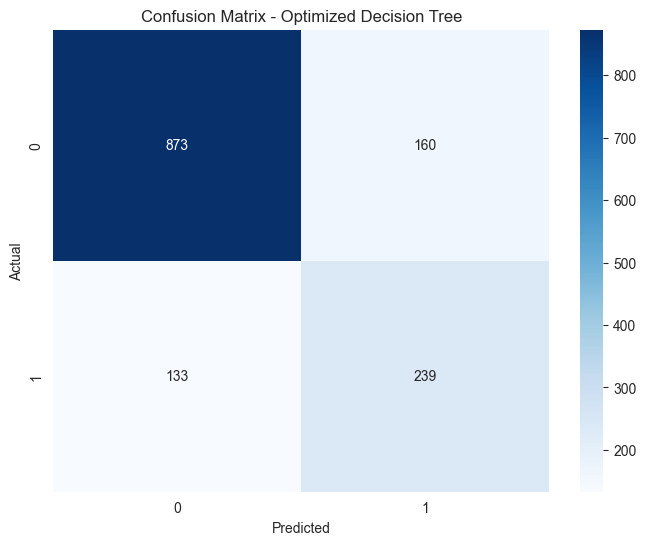

In [159]:
print("=== OPTIMIZED MODEL CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred_optimized))

conf_matrix = confusion_matrix(y_test, y_pred_optimized)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Optimized Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

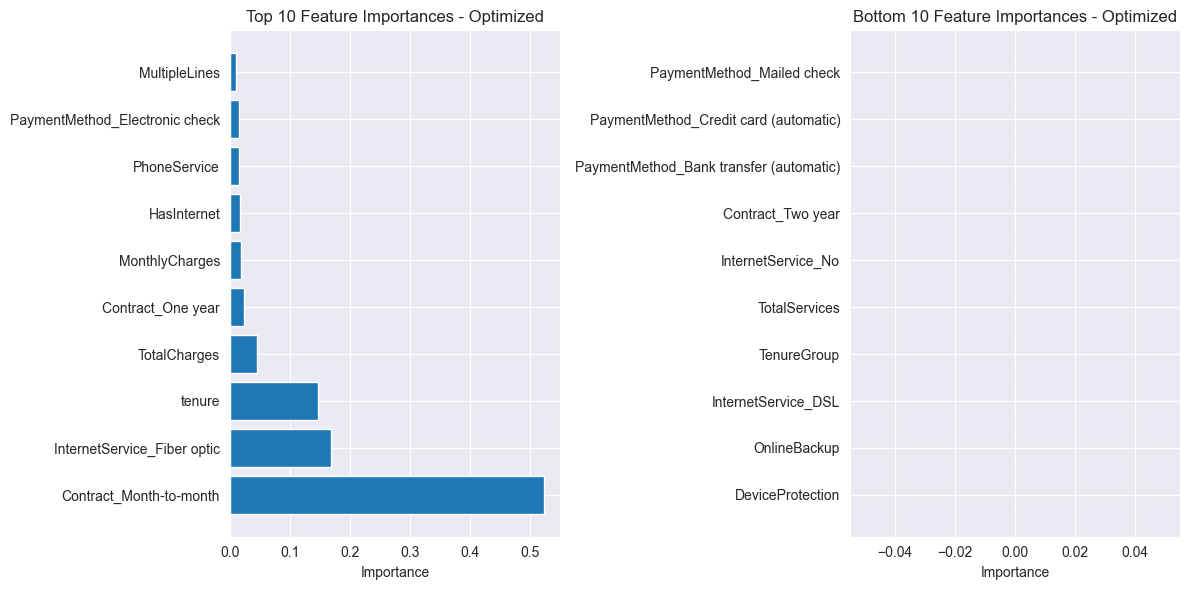

In [160]:
plt.figure(figsize=(12, 6))

feature_importance_opt = pd.DataFrame({
    'feature': X.columns,
    'importance': dt_optimized.feature_importances_
}).sort_values('importance', ascending=False)

plt.subplot(1, 2, 1)
plt.barh(feature_importance_opt.head(10)['feature'],
         feature_importance_opt.head(10)['importance'])
plt.title('Top 10 Feature Importances - Optimized')
plt.xlabel('Importance')

plt.subplot(1, 2, 2)
plt.barh(feature_importance_opt.tail(10)['feature'],
         feature_importance_opt.tail(10)['importance'])
plt.title('Bottom 10 Feature Importances - Optimized')
plt.xlabel('Importance')

plt.tight_layout()
plt.show()

In [161]:
optimized_results = {
    'model': 'DecisionTree_Optimized',
    'best_params': best_params,
    'train_accuracy': train_accuracy_opt,
    'test_accuracy': test_accuracy_opt,
    'overfitting_gap': train_accuracy_opt - test_accuracy_opt,
    'feature_importance': feature_importance_opt.head(10).to_dict()
}

print("Optimized model results saved")
print(f"Test accuracy improved by: {test_accuracy_opt - basic_results['test_accuracy']:.4f}")

Optimized model results saved
Test accuracy improved by: 0.0662


In [162]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import cross_val_score
import joblib

In [163]:
cv_scores = cross_val_score(dt_optimized, X_train, y_train, cv=5, scoring='accuracy')
print("=== CROSS-VALIDATION RESULTS ===")
print(f"CV Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

=== CROSS-VALIDATION RESULTS ===
CV Scores: [0.78914591 0.79252004 0.79252004 0.80142476 0.78183437]
Mean CV Accuracy: 0.7915 (+/- 0.0126)


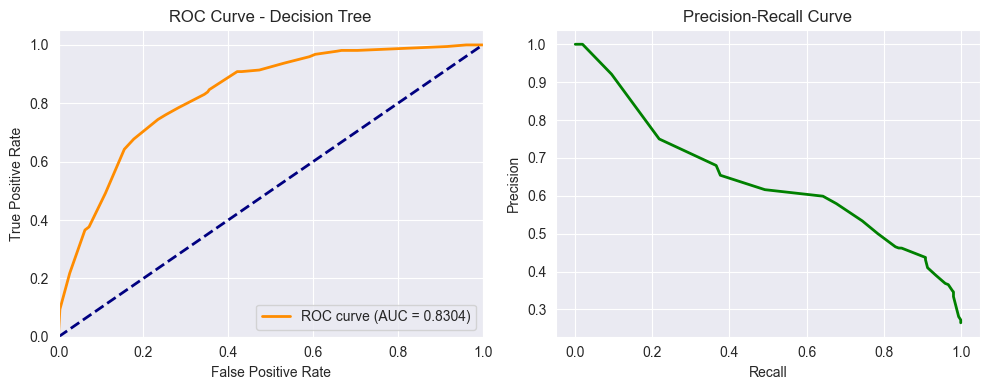

AUC Score: 0.8304


In [164]:
y_pred_proba = dt_optimized.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.tight_layout()
plt.show()

print(f"AUC Score: {roc_auc:.4f}")

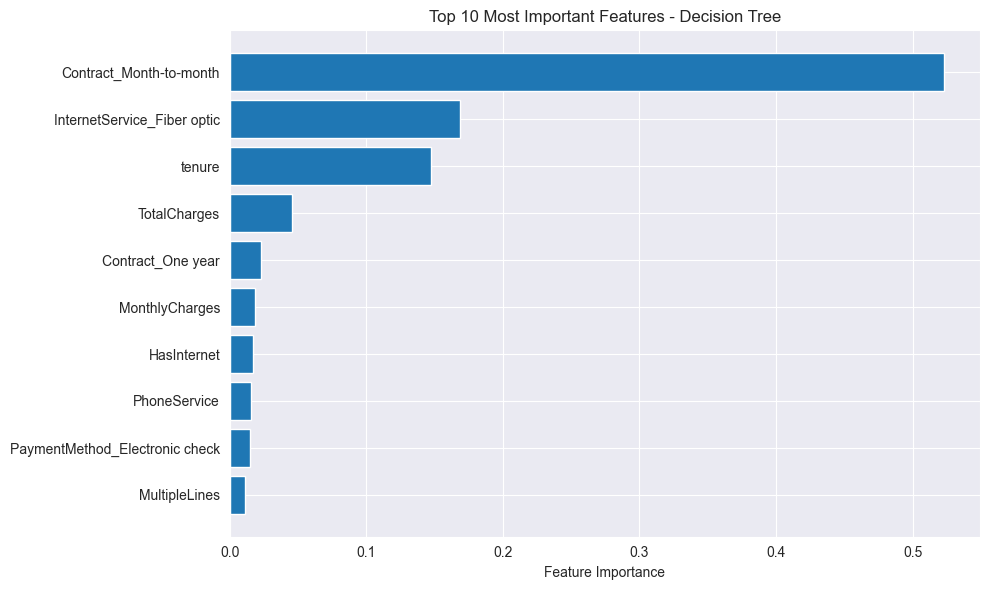

=== TOP 5 FEATURES ===
1. Contract_Month-to-month: 0.5233
2. InternetService_Fiber optic: 0.1684
3. tenure: 0.1475
4. TotalCharges: 0.0453
5. Contract_One year: 0.0228
6. MonthlyCharges: 0.0182
7. HasInternet: 0.0168
8. PhoneService: 0.0159
9. PaymentMethod_Electronic check: 0.0149
10. MultipleLines: 0.0109


In [165]:
top_features = feature_importance_opt.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Most Important Features - Decision Tree')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("=== TOP 5 FEATURES ===")
for i, (feature, importance) in enumerate(zip(top_features['feature'], top_features['importance'])):
    print(f"{i+1}. {feature}: {importance:.4f}")

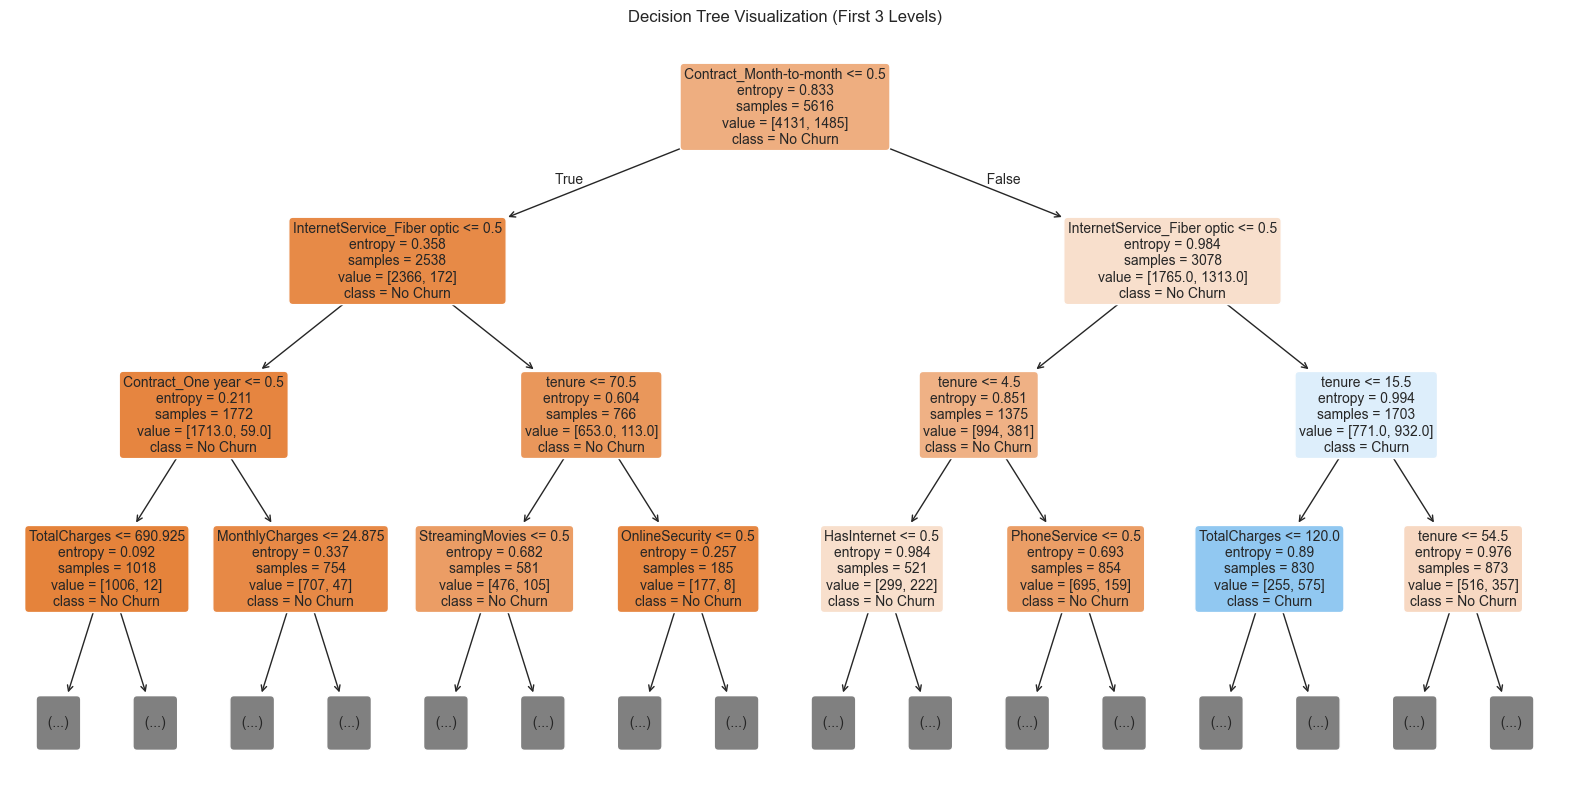

In [166]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(dt_optimized,
          feature_names=X.columns,
          class_names=['No Churn', 'Churn'],
          filled=True,
          rounded=True,
          max_depth=3,
          fontsize=10)
plt.title('Decision Tree Visualization (First 3 Levels)')
plt.show()

In [167]:
joblib.dump(dt_optimized, 'decision_tree_model.pkl')
print("Decision Tree model saved as 'decision_tree_model.pkl'")

final_dt_results = {
    'model': 'DecisionTree_Final',
    'test_accuracy': test_accuracy_opt,
    'auc_score': roc_auc,
    'cv_mean_accuracy': cv_scores.mean(),
    'top_features': top_features.to_dict()
}

print("=== FINAL DECISION TREE RESULTS ===")
for key, value in final_dt_results.items():
    if key != 'top_features':
        print(f"{key}: {value}")

Decision Tree model saved as 'decision_tree_model.pkl'
=== FINAL DECISION TREE RESULTS ===
model: DecisionTree_Final
test_accuracy: 0.7914590747330961
auc_score: 0.830351101812239
cv_mean_accuracy: 0.791489021209711


In [168]:
print("=== BUSINESS INSIGHTS ===")
print("1. Most important factors affecting churn:")
for i in range(3):
    feature = top_features.iloc[i]['feature']
    importance = top_features.iloc[i]['importance']
    print(f"   - {feature} (importance: {importance:.3f})")

print("\n2. Model can predict churn with {:.1f}% accuracy".format(test_accuracy_opt * 100))
print("3. AUC of {:.3f} indicates good discrimination ability".format(roc_auc))

=== BUSINESS INSIGHTS ===
1. Most important factors affecting churn:
   - Contract_Month-to-month (importance: 0.523)
   - InternetService_Fiber optic (importance: 0.168)
   - tenure (importance: 0.147)

2. Model can predict churn with 79.1% accuracy
3. AUC of 0.830 indicates good discrimination ability
